In [1]:
from qiskit import *
from qiskit.visualization import plot_histogram
import numpy as np
from matplotlib import pyplot as plt
import qiskit.quantum_info as qi
from qiskit.visualization import plot_bloch_multivector

In [2]:
# Theta, phi, lambdaz is the params of u3 gate
theta = np.random.uniform(0, np.pi)
phi = np.random.uniform(0, np.pi)
lambdaz = 0
# Thetas is the param of rz, rx, rz gates
thetas = np.zeros([3,])
sim = Aer.get_backend('qasm_simulator')
number_of_shot = 10000
learning_rate = 0.1

In [3]:

def u_thetas(thetas, qc):
    """Create U_thetas sub circuit

    Args:
        thetas (numpy array): Param for Rz, Rx, Rz
        qc (QuantumCircuit): current circuit

    Returns:
        QuantumCircuit: added circuit
    """
    qc.rz(thetas[0], 0)
    qc.rx(thetas[1], 0)
    qc.rz(thetas[2], 0)
    return qc
def get_psi_hat(thetas):
    a = np.exp(1j/2*(thetas[0]+thetas[2]))*np.cos(thetas[1]/2)
    b = np.exp(1j/2*(thetas[0]-thetas[2]))*1j*np.sin(thetas[1]/2)
    return np.array([a, b])
    
def construct_circuit(thetas):
    """Return one-qubit quantum circuit as instructions

    Args:
        thetas (np array): Params for U_theta gate

    Returns:
        QuantumCircuit
    """
    qc = QuantumCircuit(1, 1)
    qc.u3(theta, phi, lambdaz, 0)
    psi = qi.Statevector.from_instruction(qc)
    qc = u_thetas(thetas, qc)
    qc.measure(0, 0)
    return qc, psi
def measure(qc):
    """Get P0 values by measurement
    Args:
        qc (QuantumCircuit)
    Returns:
        float: P0
    """
    qobj = assemble(qc, shots = number_of_shot)  
    counts = sim.run(qobj).result().get_counts()
    return counts['0'] / number_of_shot
def grad(thetas1, thetas2):
    qc1, psi = construct_circuit(thetas1)
    qc2, psi = construct_circuit(thetas2)
    return -1/2*(measure(qc1) - measure(qc2))

def grad_l(thetas):
    """Calculate gradient of quantum circuit by parameter shift rule
    Here r = 1 and s = pi/4
        np array: grad of thetas
    """
    gradient_l = np.zeros(len(thetas))
    for i in range(0, len(thetas)):
        thetas1, thetas2 = thetas.copy(), thetas.copy()
        thetas1[i] += np.pi/2
        thetas2[i] -= np.pi/2
        gradient_l[i] = grad(thetas1, thetas2)
    return gradient_l

C:\Users\haime\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:30: DeprecationWarning: The QuantumCircuit.u3 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use QuantumCircuit.u instead, which acts identically. Alternatively, you can decompose u3 in terms of QuantumCircuit.p and QuantumCircuit.sx: u3(ϴ,φ,λ) = p(φ+π) sx p(ϴ+π) sx p(λ) (2 pulses on hardware).


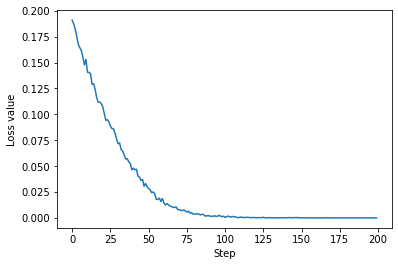

In [4]:
# Calculate loss function in 100 steps
# I confused in this point, is below code right?
ls = []
for i in range(0, 200):
    thetas = thetas - learning_rate*grad_l(thetas)
    qc, psi = construct_circuit(thetas)
    psi_hat = get_psi_hat(thetas)
    l = 1 - measure(qc)
    ls.append(l)


# print(psi_hat)
# plot_bloch_multivector(psi, title="Psi")
# plot_bloch_multivector(psi_hat, title="Psi_hat")

plt.show()
plt.plot(ls)
plt.xlabel("Step")
plt.ylabel("Loss value")
plt.show()